<a href="https://colab.research.google.com/github/Kadomium/Car_kit/blob/main/Car_kit_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
%pip install japanize-matplotlib
import japanize_matplotlib

In [4]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [5]:
#ここをサンプルのcdnoに
df_raw = pd.read_csv('/content/drive/MyDrive/Car-kit/carkit_100%.csv')
df = df_raw.copy()
df.head()

,key,qstrend,qxq999,qqkey,qs3,qxxx_1,qsk4_15,qsk4_1c,qsk4_2c,qs4_3,...,q57_117,q57_118,q57_2,q63,qxxx_10,qw3,qw7,qw11,qw5p,qw6
0,137000005,98,0.99600,6dcfd7121267effc8ba8a603233a6eace21ce331,2,NaN,1897,38,12,8,...,0,0,2,2,NaN,15,5,9400093,14,1
1,137000009,98,1.28326,2803263b7bbf69327e59981693d27af750dc7453,1,NaN,664,4,4,8,...,0,0,1,1,NaN,34,8,7310138,1,3
2,137000007,98,0.78118,c20af19f0e25d4cb7d2b9140930f1ae666315d61,3,NaN,1897,38,12,8,...,0,0,2,3,NaN,23,6,4410105,7,4
3,137000008,98,0.77699,3dfe5f849b7f9faa14c08dc1b48117745658d56d,1,NaN,227,1,1,5,...,0,0,1,3,NaN,14,4,2450063,13,3
4,137000010,98,0.65201,534a18a3770249dcaf5f358152648665217ef264,1,NaN,169,1,1,4,...,0,0,1,3,NaN,14,4,2470002,13,3


In [6]:
month_labels = {
    102: '21年12月',
    103: '22年1月',
    104: '22年2月',
    105: '22年3月',
    106: '22年4月',
    107: '22年5月',
    108: '22年6月',
    109: '22年7月',
    110: '22年8月',
    111: '22年9月',
    112: '22年10月',
    113: '22年11月',
    114: '22年12月',
    115: '23年1月',
    116: '23年2月',
    117: '23年3月',
    118: '23年4月',
    119: '23年5月',
    120: '23年6月',
    121: '23年7月',
    122: '23年8月',
    123: '23年9月',
    124: '23年10月',
    125: '23年11月',
    126: '23年12月',
    127: '24年1月',
    128: '24年2月',
    129: '24年3月',
    130: '24年4月',
    131: '24年5月',
    132: '24年6月',
    133: '24年7月',
    134: '24年8月',
    135: '24年9月',
    136: '24年10月',
    137: '24年11月',
    138: '24年12月'
}

# 1. dfからqsk4_15が426の行のみを抜き出してdf_boxと命名
df_box = df[df['qsk4_15'] == 426].copy()

# 2. qs4_4aの値ごとにサンプル数を集計
#    value_counts()で各値の出現回数を数え、sort_index()でqs4_4aの値（インデックス）で昇順に並べ替え
sample_counts_box = df_box['qs4_4a'].value_counts().sort_index()
sample_renamed_box = sample_counts_box.rename(index=month_labels)

# 1. dfからqsk4_15が426の行のみを抜き出してdf_boxと命名
df_custom = df[df['qsk4_15'] == 428].copy()

# 2. qs4_4aの値ごとにサンプル数を集計
#    value_counts()で各値の出現回数を数え、sort_index()でqs4_4aの値（インデックス）で昇順に並べ替え
sample_counts_custom = df_custom['qs4_4a'].value_counts().sort_index()
sample_renamed_custom = sample_counts_custom.rename(index=month_labels)

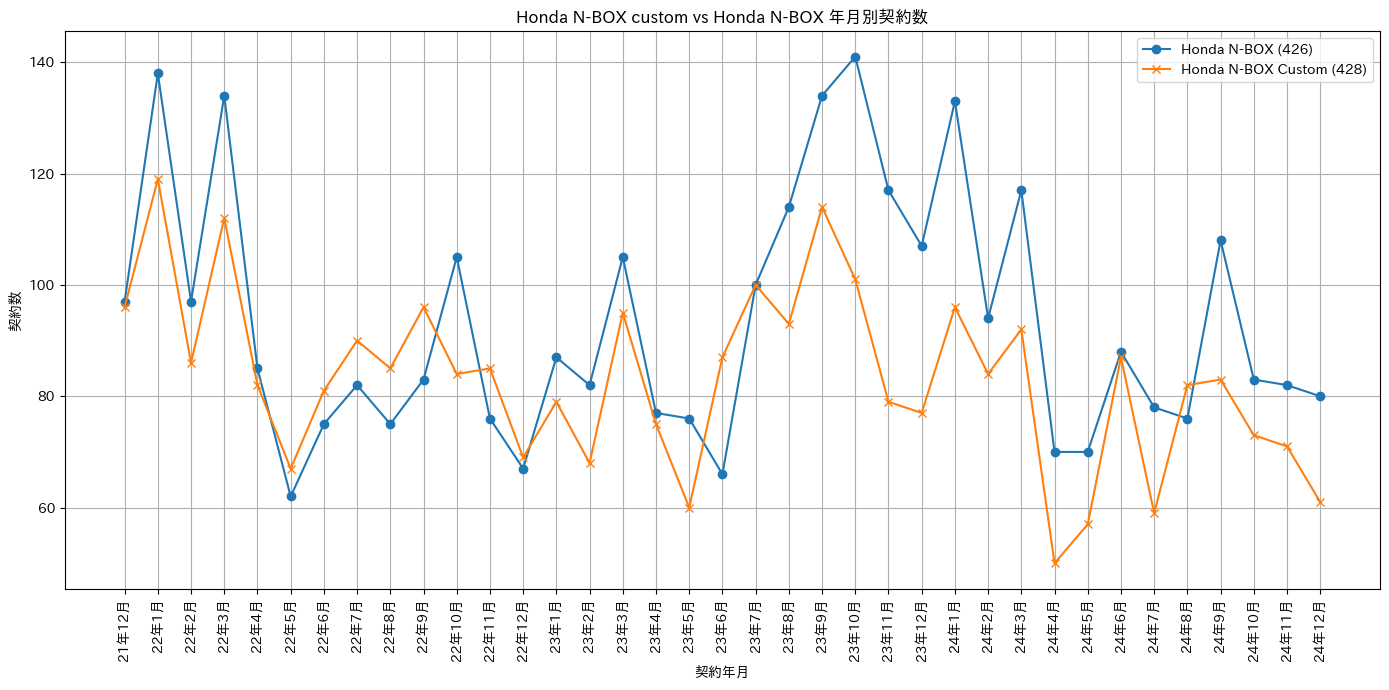

In [7]:
plt.figure(figsize=(14, 7))

# 2. 1つ目の折れ線グラフをプロット
plt.plot(
    sample_counts_custom.index,   # X軸：qs4_4aの値
    sample_counts_custom.values,  # Y軸：サンプル数
    marker='o',
    label='Honda N-BOX (426)'           # 凡例用のラベル
)

# 3. 2つ目の折れ線グラフをプロット
plt.plot(
    sample_counts_box.index,   # X軸：qs4_4aの値
    sample_counts_box.values,  # Y軸：サンプル数（元のコードのtypoを修正）
    marker='x',                # マーカーを変えて見やすくする
    label='Honda N-BOX Custom (428)'    # 凡例用のラベル
)

# 4. グラフ全体のタイトルやラベルを設定
plt.title('Honda N-BOX custom vs Honda N-BOX 年月別契約数')
plt.xlabel('契約年月')
plt.ylabel('契約数')
plt.grid(True)
plt.legend()  # labelで指定した凡例を表示

# 5. X軸の目盛りを両方のデータに合わせて設定
#   両方のデータのインデックス(qs4_4aの値)を結合し、重複を除いてソート
all_xticks = sorted(list(set(sample_counts_custom.index) | set(sample_counts_box.index)))
#   month_labels辞書を使って、数値のインデックスを年月ラベルに変換
xtick_labels = [month_labels.get(x, x) for x in all_xticks] # 辞書にないキーの場合は元の数値を表示

plt.xticks(ticks=all_xticks, labels=xtick_labels, rotation=90)

# グラフ下部の余白を調整して、回転したラベルが見切れないようにする
plt.tight_layout()

plt.savefig("n_box_custom_compare_month.png", dpi=300)

# 6. グラフを表示
plt.show()